In [4]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import pgeocode
import datetime
from math import radians
import joblib
import json
warnings.filterwarnings("ignore")
%matplotlib inline

# 1) Data Formatting

## Open Excel File in DataFrame

In [5]:
df = pd.read_excel('CarData.xlsx')

In [6]:
data = df.copy()

In [7]:
print(len(data.index))

62962


## Remove Incorrect Records

In [8]:
def find_incorrect_records(make, trim):
  if make in trim:
    return False
  return True

In [9]:
for i, row in data.iterrows():
  if find_incorrect_records(row['Make'], row['Trim']):
    data = data.drop(i)

## Remove Duplicates

In [10]:
data = data.drop_duplicates(subset=['VIN'])

In [11]:
data = data.drop('VIN', axis=1)

In [12]:
print(len(data.index))

61379


## Parse Column Information

In [13]:
def parse_year(car_string):
  match = re.search(r'\b(19|20)\d{2}\b', car_string)
  return int(match.group(0)) if match else None

def parse_trim(car_string, make, model):
  if make in car_string:
    trim = car_string.split(make, 1)[1]
    if model in trim:
      trim = trim.split(model, 1)[1]
      trim = trim.replace('for Sale', '')
      return str(trim.strip())
    else:
      return None
  else:
    return None

def parse_zip_code(location):
  if type(location) == str:
    zip = location.split(' ')[-1]
    return str(zip)
  return None

def parse_price(price):
  if type(price) == str:
    num = price.replace('$','')
    num = num.replace(',','')
    return int(num)
  return None

def parse_miles(miles):
  if type(miles) == str:
    mileage = miles.replace(' miles', '')
    mileage = mileage.replace(',','')
    return int(mileage.strip())
  return None

def parse_engine_size(engine):
  if type(engine) == str and '-cylinder' in engine:
    size = engine.replace('-cylinder','')
    return int(size.strip())
  return None

def parse_seats(seats):
  if type(seats) == str and 'seater' in seats:
    seats = seats.replace('seater','')
    return int(seats.strip())
  return None

In [14]:
data['Year'] = data['Year'].apply(parse_year)

data['Trim'] = data.apply(lambda row: parse_trim(row['Trim'], row['Make'], row['Model']), axis=1)

data['Location'] = data['Location'].apply(parse_zip_code)

data['Price'] = data['Price'].apply(parse_price)

data['Mileage'] = data['Mileage'].apply(parse_miles)

data['Engine_Size'] = data['Engine_Size'].apply(parse_engine_size)

data['Seats'] = data['Seats'].apply(parse_seats)

data.loc[data['Fuel_Type'] == 'Electric', 'Engine_Size'] = 0

data.loc[data['Fuel_Type'] == 'Natural Gas', 'Fuel_Type'] = 'Gas'

## Remove Some Null Values

In [15]:
len(data.index)

61379

In [16]:
data.sample(1)

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
20024,Ford,Fiesta,2017,SE,11101,NaN,64815.0,Automatic,Magnetic Metallic,4.0,Gas,NaN,5.0,FWD


In [17]:
data = data.drop(data[data['Trim'].isna()].index)

In [18]:
data = data.drop(data[data['Trim']==''].index)

In [19]:
len(data.index)

59749

In [20]:
data.isna().sum().sum()

np.int64(28568)

## Replace Missing Engine Size

In [21]:
print("Engine Size: ", data['Engine_Size'].unique())

Engine Size:  [ 6.  4.  0. nan  8. 12.  5. 10.  3. 16.]


In [22]:
data['Engine_Size'].isna().sum()

np.int64(758)

In [23]:
def med_engine_size(model, year, trim, data, window=2):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  median_engine_size = relevant_data['Engine_Size'].median()
  return median_engine_size if not pd.isna(median_engine_size) else np.nan

In [24]:
def fill_nan_with_median(row):
  if pd.isna(row['Engine_Size']):
    return med_engine_size(row['Model'], row['Year'], row['Trim'], data)
  return row['Engine_Size']

In [25]:
data['Engine_Size'] = data.apply(fill_nan_with_median, axis=1)

In [26]:
data['Engine_Size'].isna().sum()

np.int64(624)

## Replace Missing Fuel Type

In [27]:
print("Fuel Type: ", data['Fuel_Type'].unique())

Fuel Type:  ['Gas' 'Hybrid' 'Electric' 'Plug-in Hybrid' 'Diesel' 'Flex fuel' nan]


In [28]:
data['Fuel_Type'].isna().sum()

np.int64(538)

In [29]:
def most_common_fuel_type(model, year, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
  common_fuel_type = relevant_data['Fuel_Type'].mode()
  return common_fuel_type[0] if not common_fuel_type.empty else np.nan

In [30]:
def fill_nan_with_fuel_type(row):
  if pd.isna(row['Fuel_Type']):
    return most_common_fuel_type(row['Model'], row['Year'], data)
  return row['Fuel_Type']

In [31]:
data['Fuel_Type'] = data.apply(fill_nan_with_fuel_type, axis=1)

In [32]:
data['Fuel_Type'].isna().sum()

np.int64(85)

## Replace Missing Transmission

In [33]:
print("Transmission: ", data['Transmission'].unique())

Transmission:  ['Automatic' 'Manual' 'CVT' 'Red' nan]


In [34]:
data = data[data['Transmission'] != 'Red']

In [35]:
data['Transmission'].isna().sum()

np.int64(1418)

In [36]:
def most_common_transmission(model, year, trim, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_transmission = relevant_data['Transmission'].mode()
  return common_transmission[0] if not common_transmission.empty else np.nan

In [37]:
def fill_nan_with_transmission(row):
  if pd.isna(row['Transmission']):
    return most_common_transmission(row['Model'], row['Year'], row['Trim'], data)
  return row['Transmission']

In [38]:
data['Transmission'] = data.apply(fill_nan_with_transmission, axis=1)

In [39]:
data['Transmission'].isna().sum()

np.int64(201)

## Replace Missing Gas Mileage

In [40]:
print("Gas Mileage: ", data['Gas_Mileage'].unique())

Gas Mileage:  [ 20.  21.  22.  28.  29.  25.  24.  32.  33.  30.  18.  19.  17.  nan
  23.  15.  27.  26.  87.  77.  13.  14.  16.  12.  34.  83.  31.  68.
  54.  78.  74.  79.  85.  82.  75.  95.  93. 100.  61.  50.  60.  81.
  73.  11.  47.  10.   9.  46.  67.  36.  71.  62.  65.  64. 124. 117.
 113. 111. 118.  96. 109. 120.  91. 105.  90.  76.  69.  86.  56.  89.
  88.  92. 115. 119.  35. 108.  98. 106.  94.  84.  44.  51. 112. 116.
  40.  41.  39. 102.  70.  66. 107.  97. 103.  42.  37.  99.  53.  48.
  43.  45. 110.  38.  52. 114. 121. 127.  55.  58.  59.  80.  49. 101.
 104. 123. 125. 122.  57.  63.]


In [41]:
data['Gas_Mileage'].isna().sum()

np.int64(12800)

In [42]:
def most_common_gas_mileage(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_gas_mileage = relevant_data['Gas_Mileage'].mode()
  return common_gas_mileage[0] if not common_gas_mileage.empty else np.nan

In [43]:
def fill_nan_with_gas_mileage(row):
  if pd.isna(row['Gas_Mileage']):
    return most_common_gas_mileage(row['Model'], row['Year'], row['Trim'], data)
  return row['Gas_Mileage']

In [44]:
data['Gas_Mileage'] = data.apply(fill_nan_with_gas_mileage, axis=1)

In [45]:
data['Gas_Mileage'].isna().sum()

np.int64(8262)

## Replace Missing Drive Type

In [46]:
print("Drive Type: ", data['Drive_Type'].unique())

Drive Type:  ['FWD' 'AWD' 'RWD' 'FOUR_WD' nan '4 seater' 'FOUR_X_FOUR' '7 seater'
 'FOUR_X_TWO' 'JTJBC1BA4D2050855']


In [47]:
data = data.drop(data[data['Drive_Type'] == 'JTJBC1BA4D2050855'].index)
data = data.drop(data[data['Drive_Type'] == '4 seater'].index)
data = data.drop(data[data['Drive_Type'] == '7 seater'].index)
replacements = {
    'FOUR_WD': 'AWD',
    'FOUR_X_FOUR': 'AWD',
    'FOUR_X_TWO': 'RWD'
}

data['Drive_Type'] = data['Drive_Type'].replace(replacements)

In [48]:
data['Drive_Type'].isna().sum()

np.int64(704)

In [49]:
def most_common_drive_type(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_drive_type = relevant_data['Drive_Type'].mode()
  return common_drive_type[0] if not common_drive_type.empty else np.nan

In [50]:
def fill_nan_with_drive_type(row):
  if pd.isna(row['Drive_Type']):
    return most_common_drive_type(row['Model'], row['Year'], row['Trim'], data)
  return row['Drive_Type']

In [51]:
data['Drive_Type'] = data.apply(fill_nan_with_drive_type, axis=1)

In [52]:
data['Drive_Type'].isna().sum()

np.int64(533)

## Replace Missing Mileage

In [53]:
data['Mileage'].isna().sum()

np.int64(2753)

In [54]:
def average_mileage(model, year, data, window=1):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
    avg_mlg = relevant_data['Mileage'].mean()
    if pd.isna(avg_mlg):
        return np.nan
    noise = avg_mlg*0.05
    return np.random.normal(avg_mlg, noise)

In [55]:
def fill_nan_with_miles(row):
  if pd.isna(row['Mileage']):
    return average_mileage(row['Model'], row['Year'], data)
  return row['Mileage']

In [56]:
data['Mileage'] = data.apply(fill_nan_with_miles, axis=1)

In [57]:
data['Mileage'].isna().sum()

np.int64(56)

## Fixing Incorrect Colors

In [58]:
def is_number(s):
    s = str(s)
    return not s.isdigit()

In [59]:
mask = data['Color'].apply(is_number)
data = data[mask]

In [60]:
data = data[data['Color']!='--']

In [61]:
def remove_square_brackets(s):
    s = str(s)
    return re.sub(r'\[.*?\]', '', s).strip()

In [62]:
data['Color'] = data['Color'].apply(remove_square_brackets)

## Removing Final Null/Incorrect Values

In [63]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
50336,Nissan,Xterra,2006,S,21014,10998.0,105683.0,Automatic,Night Armor Clearcoat,6.0,Gas,16.0,5.0,AWD


In [64]:
print("Price: ", data['Price'].isna().sum())
print("Mileage: ", data['Mileage'].isna().sum())
print("Transmission: ", data['Transmission'].isna().sum())
print("Color: ", data['Color'].isna().sum())
print("Engine_Size: ", data['Engine_Size'].isna().sum())
print("Fuel_Type: ", data['Fuel_Type'].isna().sum())
print("Gas Mileage: ", data['Gas_Mileage'].isna().sum())
print("Drive_Type: ", data['Drive_Type'].isna().sum())

Price:  6421
Mileage:  56
Transmission:  201
Color:  0
Engine_Size:  624
Fuel_Type:  85
Gas Mileage:  8244
Drive_Type:  532


In [65]:
data.isna().sum().sum()

np.int64(16498)

In [66]:
data = data.dropna()

In [67]:
len(data.index)

45897

In [68]:
data.isna().sum().sum()

np.int64(0)

In [69]:
# removing seats drops MAE
data = data.drop(columns=['Seats'])

In [70]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
49360,Nissan,NV200,2021,S,07849,15999.0,97021.0,CVT,White,4.0,Gas,25.0,FWD


## Add Coordinates From Zip Code

In [71]:
nomi = pgeocode.Nominatim('us')


latitudes = []
longitudes = []

for zip_code in data['Location']:
    location = nomi.query_postal_code(zip_code)
    latitudes.append(location.latitude if location is not None else None)
    longitudes.append(location.longitude if location is not None else None)

data['Latitude'] = latitudes
data['Longitude'] = longitudes
data['Latitude'] = data['Latitude'].apply(radians)
data['Longitude'] = data['Longitude'].apply(radians)


In [72]:
data = data.drop(columns=['Location'])

## Replace Year Column

In [73]:
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year'].astype(int)
data = data.drop(columns='Year')

In [74]:
data.sample(5)

,Make,Model,Trim,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Age
38562,Lexus,RC 350,Base,18163.0,102076.0,Automatic,Nebula Gray Pearl,6.0,Gas,21.0,AWD,0.674318,-1.348586,9
57981,Toyota,Land Cruiser,Base,9995.0,270140.0,Automatic,Blue,8.0,Gas,13.0,AWD,0.695695,-1.303225,24
24846,Honda,Element,DX,2195.0,307805.0,Automatic,Silver,4.0,Gas,20.0,AWD,0.711508,-1.294502,21
43370,McLaren,650S Spider,Base,139575.0,15825.0,Automatic,White,8.0,Gas,18.0,RWD,0.519099,-1.666620,9
52721,Ram,Ram Pickup 1500,Tradesman,18995.0,132150.0,Automatic,Patriot Blue Pearlcoat,8.0,Gas,17.0,AWD,0.709907,-1.295451,5


In [75]:
data = data.dropna()

In [76]:
data = data[data['Age']!=-1]

In [77]:
len(data.index)

45057

## Format Dataframe

In [78]:
price = data.pop('Price')
data.insert(13, 'Price', price)

In [79]:
age = data.pop('Age')
data.insert(2, 'Age', age)

In [80]:
data.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
20217,Ford,Flex,6,SEL,102484.0,Automatic,White Gold Metallic,6.0,Gas,18.0,AWD,0.746587,-1.453419,14175.0


# 2) Exploratory Data Analysis

In [ ]:
# Find the total number of cars per manufacturer in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data['Make'])
plt.title("Manufacturer Distribution")
plt.show()

In [ ]:
# Find the number of cars made in each year in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Age, palette='viridis')
plt.title("Year Distribution")
plt.show()

In [ ]:
# Number of cars per transmission type
plt.figure(figsize=(20, 15))
sns.countplot(x=data.Transmission, palette='Paired')
plt.title("Transmission Distribution")
plt.show()

In [ ]:
# unique elements in data
data.nunique()

In [ ]:
# fuel type distribution
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Fuel_Type.sort_values(ascending=False), palette='Dark2')


In [ ]:
# Group rows by make
data.groupby('Make')[['Engine_Size','Gas_Mileage', 'Price']].agg(['min','max','mean','median'])

In [ ]:
# average price by year
plt.figure(figsize=(20, 10))
data.groupby('Age')['Price'].mean().plot(kind='bar',color='g')
plt.title('Average Price by Year')
plt.show()

In [ ]:
plt.figure(figsize = (10, 10))
data.groupby('Transmission')['Price'].mean().plot(kind = 'bar', color = 'y')
plt.title("Average Price by Transmission", fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
data.groupby(['Make'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'black')
plt.title("Average Price per Manufacturer", fontsize = 20)
plt.show()

In [ ]:
# Group by Drive Type
plt.figure(figsize = (20, 15))
data.groupby(['Drive_Type'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'orange')

In [ ]:
sns.scatterplot(x='Engine_Size',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
# Boxplot of MPG
sns.boxplot(x='Gas_Mileage', data=data,color='r')

In [ ]:
sns.scatterplot(x='Fuel_Type',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
numeric_columns = ['Age', 'Mileage', 'Engine_Size', 'Price']
heatmap_data = data[numeric_columns].corr()
sns.heatmap(heatmap_data, annot=True, cmap='BuPu')

In [ ]:
# Gas Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Gas_Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Gas Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
# Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
data.info()

# 3) Data Manipulation

In [81]:
print(len(data.index))

45057


In [82]:
frame = data.copy()

In [83]:
frame.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
38160,Lexus,NX 300h,4,Base,72477.0,CVT,Black,4.0,Hybrid,31.0,AWD,0.619552,-1.70575,29666.0


## Split the Data

In [84]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [85]:
# Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [86]:
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (36045, 13)
The size of the output train data is: (36045,)
The size of the input test data is: (9012, 13)
The size of the output test data is: (9012,)


In [87]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
9492,Cadillac,XT6,3,Premium Luxury,22034.0,Automatic,Black,6.0,Gas,21.0,AWD,0.709689,-1.315809


## Encode Make

In [88]:
make_encoder = TargetEncoder(cols='Make')

In [89]:
make_encoder.fit(X_train['Make'], y_train.to_frame()['Price'])

TargetEncoder(cols=['Make'])

In [90]:
X_train['Make'] = make_encoder.transform(X_train['Make'])

In [91]:
X_test['Make'] = make_encoder.transform(X_test['Make'])

In [92]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
28400,22799.433777,Veracruz,16,Limited,87236.0,Automatic,Silver,6.0,Gas,18.0,AWD,0.621515,-1.550097


## Encode Model

In [93]:
model_encoder = TargetEncoder(cols='Model')
model_encoder.fit(X_train['Model'], y_train.to_frame()['Price'])
X_train['Model'] = model_encoder.transform(X_train['Model'])
X_test['Model'] = model_encoder.transform(X_test['Model'])

In [94]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
24886,18353.338912,11010.65339,17,LX,112246.0,Manual,Silver,4.0,Gas,20.0,FWD,0.692709,-1.507823


## Encode Trim

In [95]:
trim_encoder = TargetEncoder(cols='Trim')
trim_encoder.fit(X_train['Trim'], y_train.to_frame()['Price'])
X_train['Trim'] = trim_encoder.transform(X_train['Trim'])
X_test['Trim'] = trim_encoder.transform(X_test['Trim'])

In [96]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
1515,53526.658031,25463.643929,8,18923.985689,55490.0,Automatic,Brilliant Black/Red Roof,4.0,Flex fuel,17.0,AWD,0.710609,-1.2979


## Encode Color

In [97]:
color_encoder = TargetEncoder(cols='Color')
color_encoder.fit(X_train['Color'], y_train.to_frame()['Price'])
X_train['Color'] = color_encoder.transform(X_train['Color'])
X_test['Color'] = color_encoder.transform(X_test['Color'])

In [98]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
28187,22799.433777,11797.931518,8,49968.495166,103296.0,Automatic,24910.915571,4.0,Gas,28.0,FWD,0.713471,-1.29343


## One Hot Encoding

In [99]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
56430,27785.929134,12415.725272,19,15816.125709,63101.0,Automatic,42230.599206,4.0,Gas,25.0,FWD,0.709094,-1.290613


In [100]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_train = encoder.transform(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_test = encoder.transform(X_test[['Transmission', 'Fuel_Type', 'Drive_Type']])

In [101]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)

In [102]:
X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)

In [103]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
11372,19035.746009,12624.697839,5,15855.404317,116460.0,32804.552336,4.0,28.0,0.713672,-1.299249,...,0,1,0,0,0,0,0,0,0,1


In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36045 entries, 11049 to 32382
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Make            36045 non-null  float64
 1   Model           36045 non-null  float64
 2   Age             36045 non-null  int64  
 3   Trim            36045 non-null  float64
 4   Mileage         36045 non-null  float64
 5   Color           36045 non-null  float64
 6   Engine_Size     36045 non-null  float64
 7   Gas_Mileage     36045 non-null  float64
 8   Latitude        36045 non-null  float64
 9   Longitude       36045 non-null  float64
 10  Transmission_1  36045 non-null  int64  
 11  Transmission_2  36045 non-null  int64  
 12  Transmission_3  36045 non-null  int64  
 13  Fuel_Type_1     36045 non-null  int64  
 14  Fuel_Type_2     36045 non-null  int64  
 15  Fuel_Type_3     36045 non-null  int64  
 16  Fuel_Type_4     36045 non-null  int64  
 17  Fuel_Type_5     36045 non-null  

## Standardization/Normalization

In [105]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
55807,34588.063025,36168.989511,10,33576.455476,134184.0,30865.922774,0.0,89.0,0.699238,-1.308979,...,0,0,0,1,0,0,0,1,0,0


In [106]:
cols_to_scale = ['Age', 'Mileage', 'Engine_Size', 'Gas_Mileage', 'Latitude', 'Longitude']

In [107]:
# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [108]:
X_train.shape

(36045, 22)

# 4) Machine Learning Analysis

In [109]:
mse = []
mae = []

## K-Neighbors Regressor

In [110]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

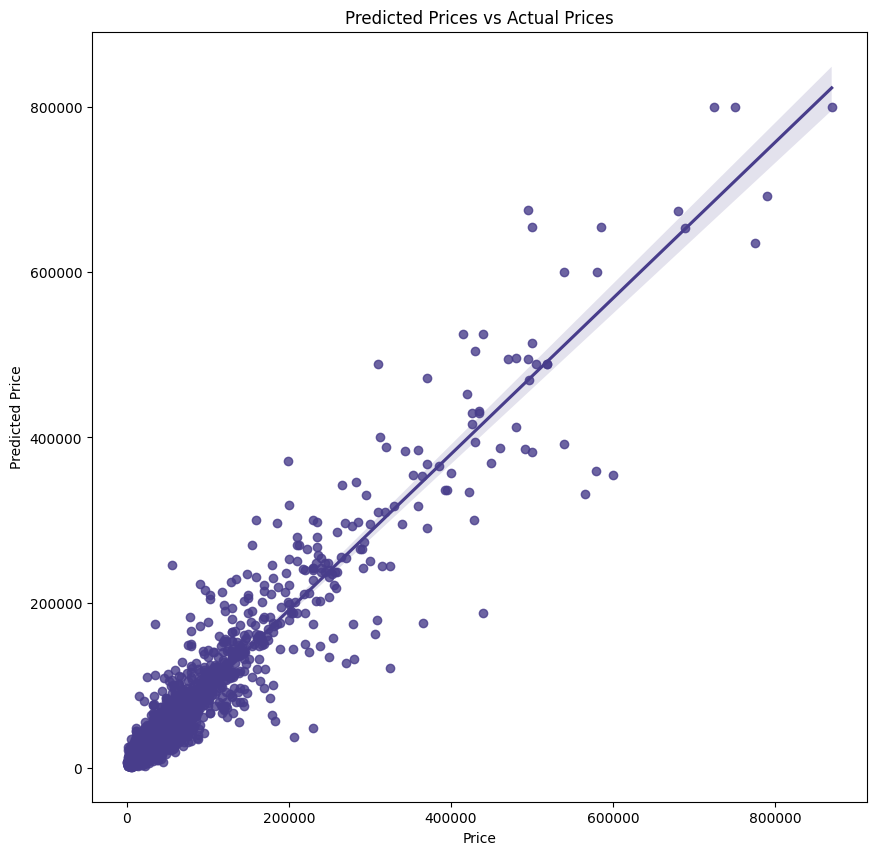

In [111]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkslateblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## PLS Regression

In [112]:
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

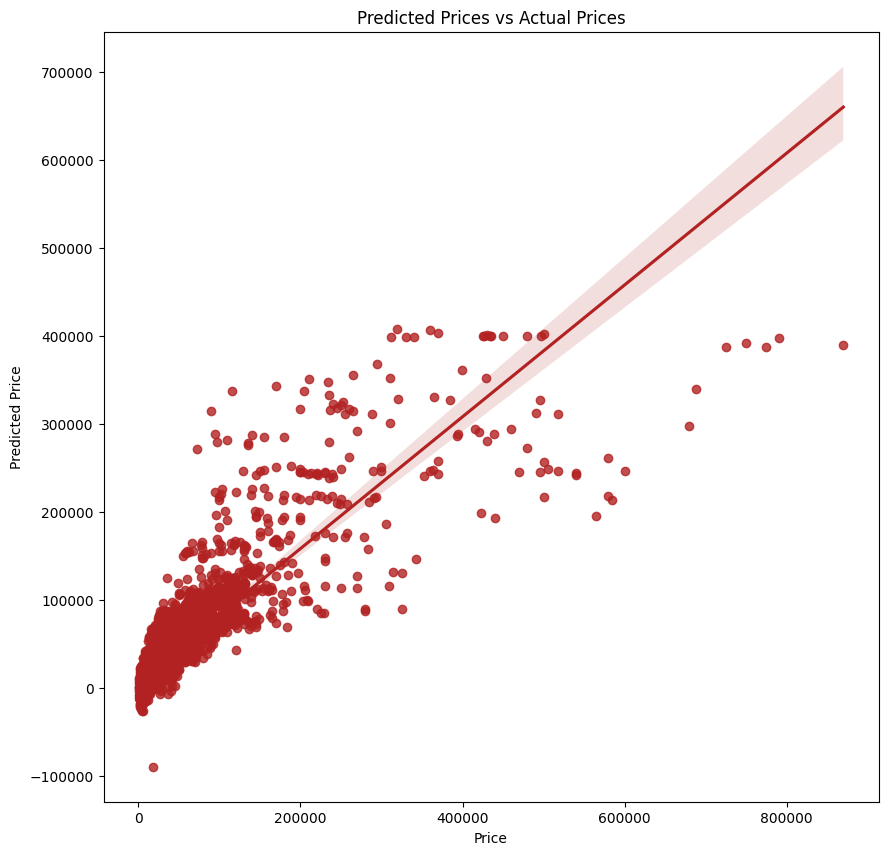

In [113]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='firebrick', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Decision Tree Regressor

In [114]:
dt = DecisionTreeRegressor(splitter='random')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

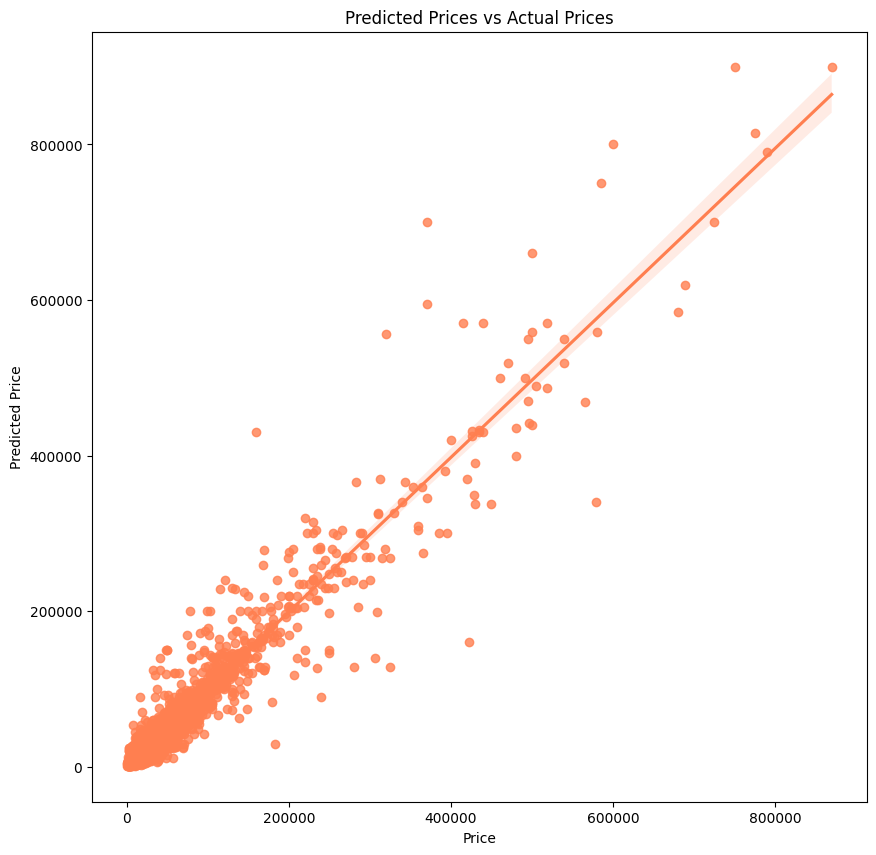

In [115]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Random Forest Regressor

In [116]:
rf = RandomForestRegressor(n_estimators=1900, max_depth=110)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

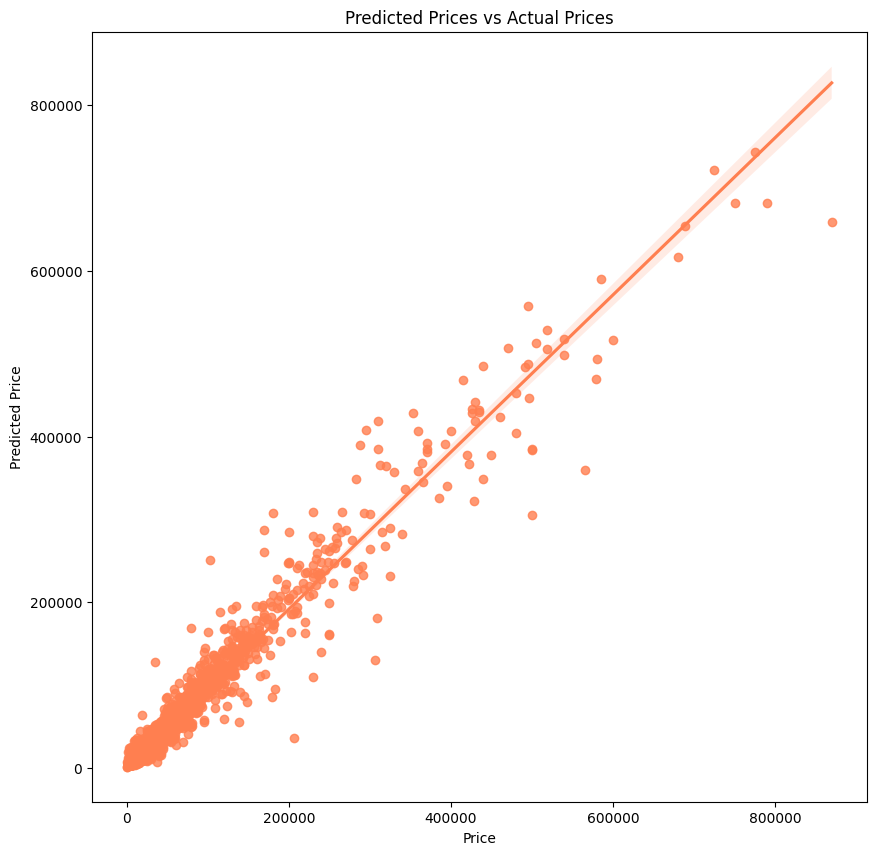

In [117]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Gradient Boosting Regressor

In [118]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

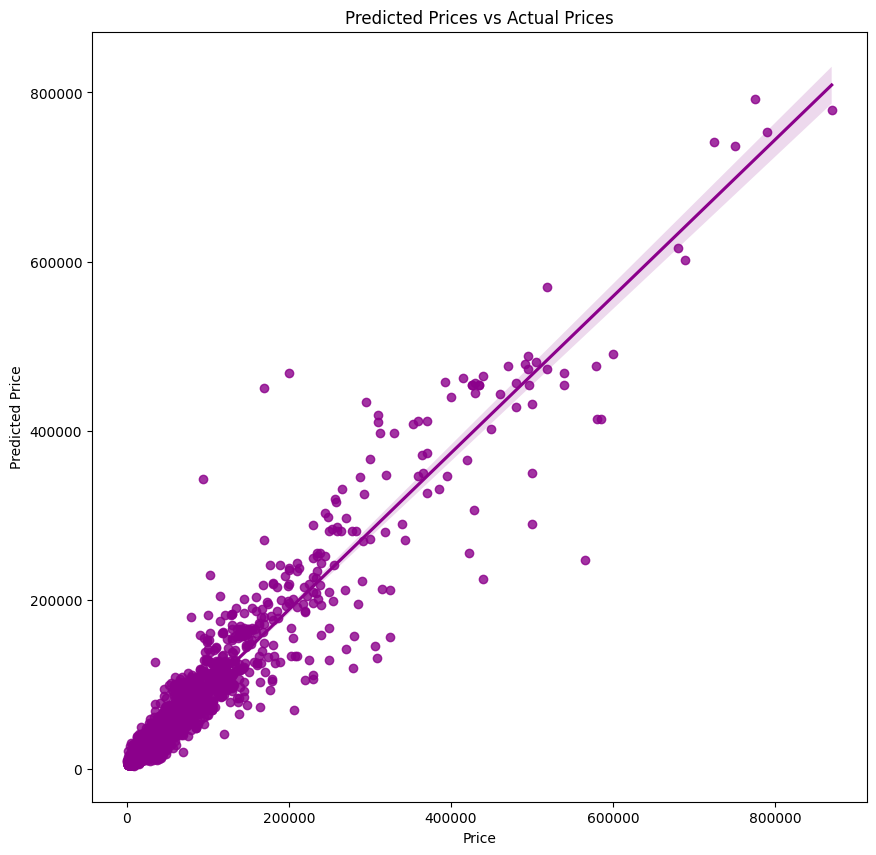

In [119]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkmagenta', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## MLP Regressor

In [120]:
mlp = MLPRegressor(hidden_layer_sizes=70, alpha=0.001, solver='adam', learning_rate='adaptive')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

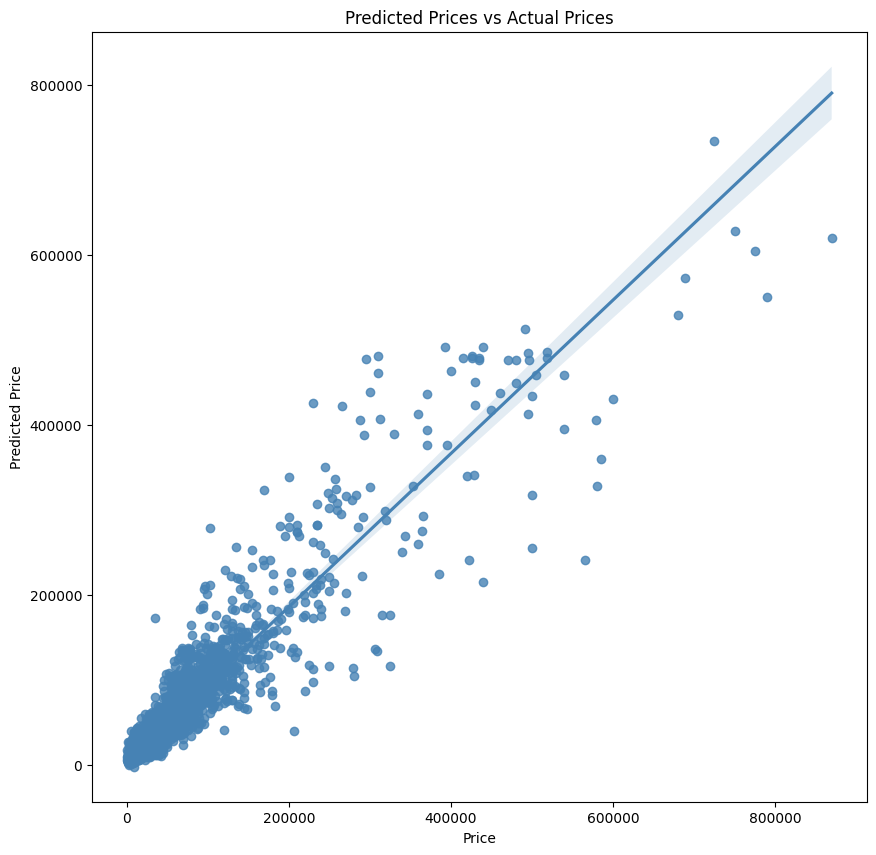

In [121]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='steelblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Dataframe of Machine Learning Models

In [122]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse}
model_dataframe = pd.DataFrame(models)

In [123]:
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,K Nearest Regressor,6127,208148483
1,PLS Regression,10905,614788680
2,Decision Tree Regressor,4897,185329094
3,Random Forest Regressor,3577,97436348
4,Gradient Boosting Regressor,5918,192213320
5,MLP Regressor,8264,307747733


## Barplot of Machine Learning Models

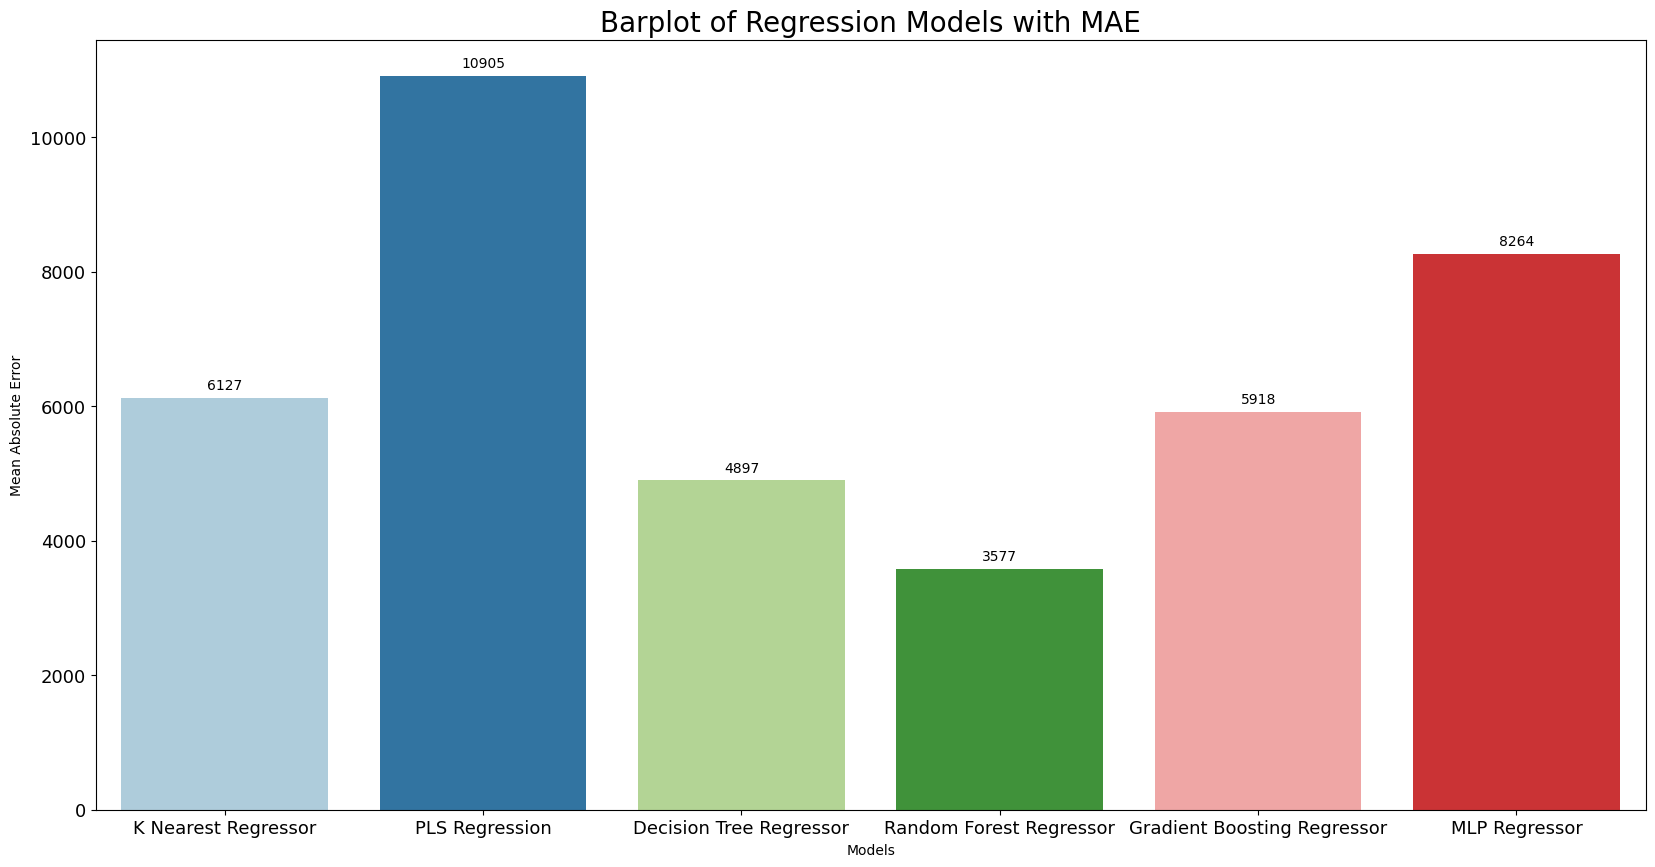

In [124]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Absolute Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MAE", fontsize = 20)
plt.show()

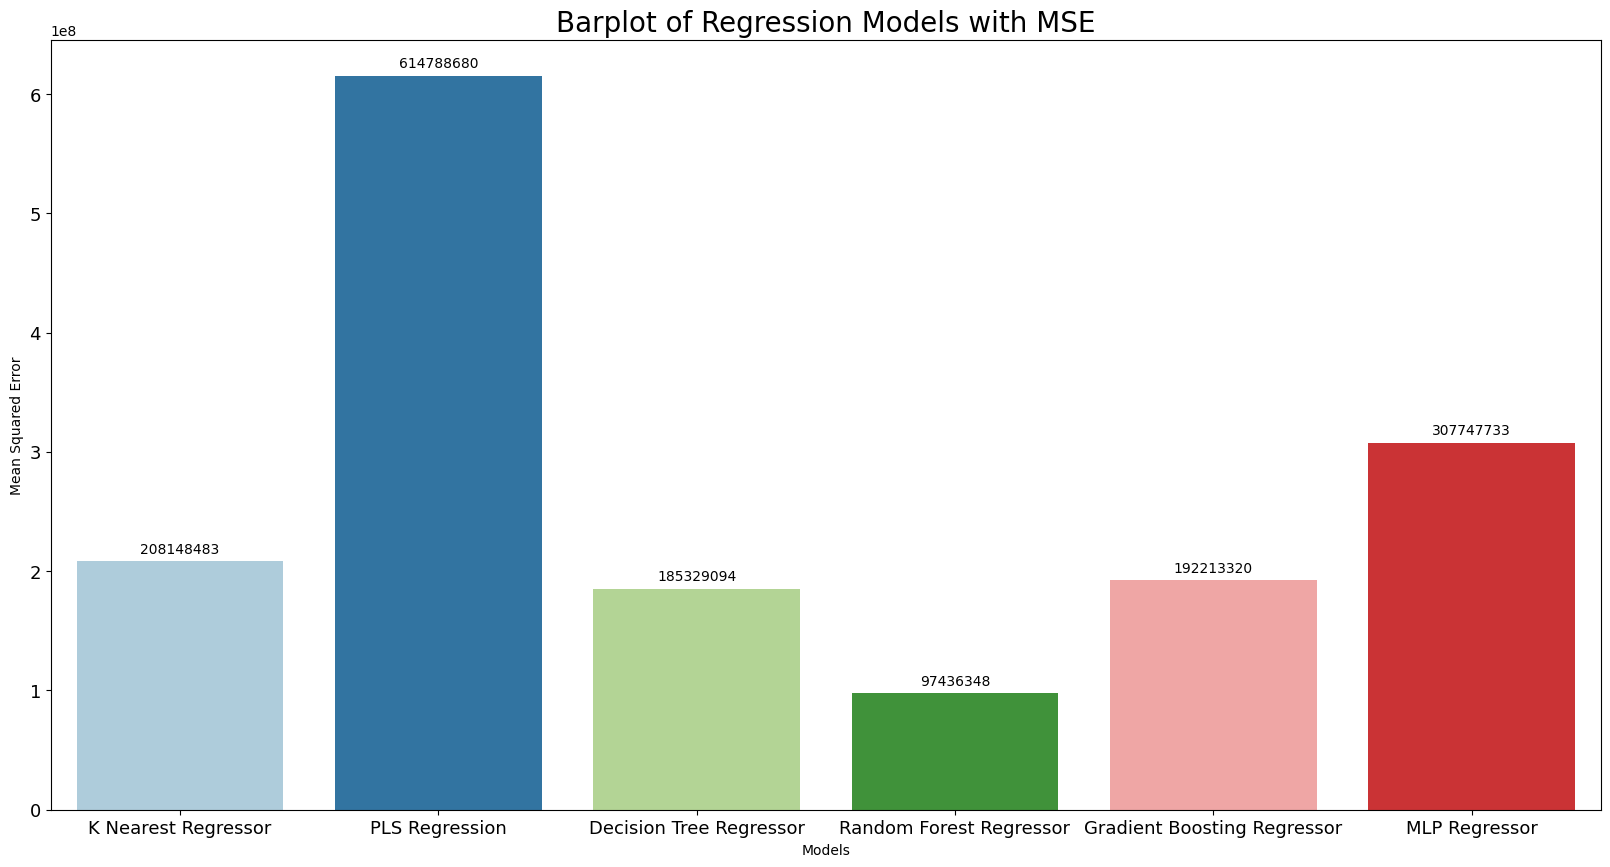

In [125]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Squared Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MSE", fontsize = 20)
plt.show()

# 4b) Data Manipulation + Machine Learning w/k-Fold

## Data Manipulation

In [ ]:
frame = data.copy()

In [ ]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [ ]:
kf = KFold(n_splits=5, shuffle=True,random_state=1)

In [ ]:
target_encoder = TargetEncoder()
one_hot_encoder = OneHotEncoder()

In [ ]:
target_encoding_features = ['Make', 'Model', 'Trim', 'Color']
one_hot_encoding_features = ['Transmission', 'Fuel_Type', 'Drive_Type']

## Machine Learning

In [ ]:
mse = []
mae = []

In [ ]:
def train_evaluate(model,X_train,y_train,X_test,mse,mae):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(int(mean_squared_error(y_pred, y_test)))
    mae.append(int(mean_absolute_error(y_pred, y_test)))

In [ ]:
model_dict = {
    'knn' : KNeighborsRegressor(),
    'pls' : PLSRegression(),
    'dt' : DecisionTreeRegressor(),
    'rf' : RandomForestRegressor(),
    'gb' : GradientBoostingRegressor(),
    'mlp' : MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
}

In [ ]:
results = {model_name: {'mae': [], 'mse': []} for model_name in model_dict.keys()}

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train[target_encoding_features] = target_encoder.fit_transform(X_train[target_encoding_features], y_train)
    X_test[target_encoding_features] = target_encoder.transform(X_test[target_encoding_features])

    one_hot_encoded_output_train = one_hot_encoder.fit_transform(X_train[one_hot_encoding_features])
    one_hot_encoded_output_test = one_hot_encoder.transform(X_test[one_hot_encoding_features])
    X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
    X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)  
    X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    
    for model_name, metrics in results.items():
        model = model_dict[model_name]
        train_evaluate(model,X_train,y_train,X_test,results[model_name]['mse'], results[model_name]['mae'])

In [ ]:
results_dataframe = pd.DataFrame(results)

In [ ]:
results_dataframe

# 4c) Random Forest Testing

Use Random Search to narrow down hyperparameter range and then GridSearch to search possible hyperparameter combinations

In [ ]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mae = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    print('Model Performance')
    print('Mean Absolute Error (MAE): {:0.4f}'.format(mae))
    print('Mean Absolute Percentage Error (MAPE): {:0.2f}%'.format(mape))
    return mae, mape

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
max_features = ['sqrt','log2']
min_samples_split = [2, 4, 8, 10]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=1, n_jobs=5)

In [ ]:
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 1)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
best_params = rf_random.best_params_

In [ ]:
param_grid = {
    'n_estimators': [int(best_params['n_estimators'])-100, [int(best_params['n_estimators']), [int(best_params['n_estimators'])+100]]],
    'max_depth': [int(best_params['max_depth'])-5, int(best_params['max_depth']), int(best_params['max_depth'])+5],
    'max_features':[best_params['max_features']],
    'min_samples_split':[int(best_params['min_samples_split']) - 1, int(best_params['min_samples_split']), int(best_params['min_samples_split']) + 1],
    'min_samples_leaf': [int(best_params['min_samples_leaf']) - 1, int(best_params['min_samples_leaf']), int(best_params['min_samples_leaf']) + 1],
    'bootstrap':[best_params['bootstrap']]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=5, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

# 4d) Gradient Boosting Testing

# 5) Predict 

Best Model: 
- Random Forest Regressor: 3598 MAE; 99988885 MSE
- target encoding on make model trim color
- onehot encoding on transmission fuel_type drive_type
- no scaling on Mileage, Engine_Size, Gas_Mileage, Latitude, Longitude
- coordinates in degrees

In [126]:
new_car = pd.DataFrame({
    'Make':['Audi'],
    'Model':['A8'],
    'Age':['2023'],
    'Trim':['quattro 55 TFSI'],
    'Mileage':7800,
    'Color':['Vesuvius Gray Metallic'],
    'Engine_Size':6,
    'Gas_Mileage':22,
    'Location':['08550'],
    'Transmission':['Automatic'],
    'Fuel_Type':['Gas'],
    'Drive_Type':['AWD'],
})

# replace year with age
current_year = datetime.datetime.now().year
new_car['Age'] = current_year - new_car['Age'].astype(int)

# get coordinates from zip code
nomi = pgeocode.Nominatim('us')
location = nomi.query_postal_code(new_car['Location'][0])
new_car['Latitude'] = location.latitude 
new_car['Longitude'] = location.longitude 
new_car = new_car.drop(columns=['Location'])

# target encoding
new_car['Make'] = make_encoder.transform(new_car['Make'])
new_car['Model'] = model_encoder.transform(new_car['Model'])
new_car['Trim'] = trim_encoder.transform(new_car['Trim'])
new_car['Color'] = color_encoder.transform(new_car['Color'])

# one hot encoding
categorical_features = new_car[['Transmission', 'Fuel_Type', 'Drive_Type']]
one_hot_encoded_new_car = encoder.transform(categorical_features)

one_hot_encoded_new_car_df = pd.DataFrame(one_hot_encoded_new_car, columns=encoder.get_feature_names_out())
new_car = pd.concat([new_car.drop(columns=['Transmission', 'Fuel_Type', 'Drive_Type']), one_hot_encoded_new_car_df], axis=1)



In [127]:
new_car

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
0,53526.658031,47367.575434,1,65833.474127,7800,36174.928045,6,22,40.2669,-74.6511,...,0,1,0,0,0,0,0,0,1,0


In [128]:
predicted_price = rf.predict(new_car)
print(predicted_price)

[70541.05052632]


# 6) Export Required Information

## Export Best Model

In [129]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

## Export Makes to Models

In [130]:
makes_to_models = data.groupby('Make')['Model'].apply(lambda x: sorted(set(x))).to_dict()

In [131]:
print(makes_to_models)

{'AMC': ['Eagle 30'], 'Acura': ['CL', 'ILX', 'Integra', 'Legend', 'MDX', 'NSX', 'RDX', 'RL', 'RLX', 'RSX', 'SLX', 'TL', 'TLX', 'TSX', 'TSX Sport Wagon', 'ZDX'], 'Alfa Romeo': ['4C', 'GTV6', 'Giulia', 'Spider', 'Stelvio', 'Tonale'], 'Aston Martin': ['DB11', 'DB12', 'DB9', 'DBS', 'DBX', 'Rapide AMR', 'Rapide S', 'V12 Vanquish', 'V12 Vantage', 'V8 Vantage', 'Vanquish', 'Vantage', 'Virage'], 'Audi': ['4000', 'A3', 'A3 Sportback e-tron', 'A4', 'A4 allroad', 'A5', 'A5 Sportback', 'A6', 'A6 allroad', 'A7', 'A8', 'Allroad', 'Cabriolet', 'Q3', 'Q4 e-tron', 'Q4 e-tron Sportback', 'Q5', 'Q5 Hybrid', 'Q5 Sportback', 'Q7', 'Q8', 'Q8 e-tron', 'Q8 e-tron Sportback', 'R8', 'RS 3', 'RS 4', 'RS 5', 'RS 5 Sportback', 'RS 6 Avant', 'RS 7', 'RS Q8', 'RS6', 'S3', 'S4', 'S5', 'S5 Sportback', 'S6', 'S7', 'S8', 'SQ5', 'SQ5 Sportback', 'SQ7', 'SQ8', 'SQ8 e-tron', 'SQ8 e-tron Sportback', 'TT', 'TT RS', 'TTS', 'e-tron', 'e-tron GT', 'e-tron Sportback'], 'BMW': ['1 Series', '2 Series', '3 Series', '4 Series', '5 S

In [132]:
with open('dropdown_info/makes_to_models.json', 'w') as f:
    json.dump(makes_to_models, f, indent=4)

## Export Makes and Models to Trims

In [133]:
makes_models_trims = data.groupby(['Make', 'Model'])['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [134]:
print(makes_models_trims)

{('AMC', 'Eagle 30'): ['Base'], ('Acura', 'CL'): ['2.3 Premium', '3.2', '3.2 Type-S'], ('Acura', 'ILX'): ['2.0L', '2.0L w/Tech', '2.4L w/Premium', '8-Spd AT w/ Premium Package', 'Base', 'Premium & A-SPEC Packages', 'Premium Package', 'Premium Pkg Sedan 4D', 'Sedan 4D', 'Standard', 'Technology & A-SPEC Pkgs Sedan 4D', 'Technology Package', 'Technology Pkg Sedan 4D', 'Technology/A-Spec Package', 'w/Premium', 'w/Premium/A-SPEC Package', 'w/Premium/A-SPEC Pkg', 'w/Special Edition', 'w/Tech', 'w/Technology/A-SPEC Package', 'with Premium and A-Spec Package'], ('Acura', 'Integra'): ['Base', 'Type S', 'w/A-SPEC', 'w/Tech w/A-SPEC'], ('Acura', 'Legend'): ['Base', 'GS', 'L'], ('Acura', 'MDX'): ['Base', 'SH-AWD', 'SH-AWD Sport Utility 4D', 'SH-AWD w/A-SPEC', 'SH-AWD w/Advance', 'SH-AWD w/Advance w/RES', 'SH-AWD w/Power Tailgate w/Tech', 'SH-AWD w/Tech', 'SH-AWD w/Tech w/RES', 'Technology Package', 'Touring w/Navi w/RES', 'w/Tech'], ('Acura', 'NSX'): ['Base', 'NSX-T', 'SH-AWD Sport Hybrid', 'SH-AW

In [135]:
json_compatible = {f"{make}_{model}": trims for (make, model), trims in makes_models_trims.items()}

In [136]:
with open('dropdown_info/makes_models_to_trims.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

## Export Makes and Models to Colors

In [137]:
makes_models_colors = data.groupby(['Make', 'Model'])['Color'].apply(lambda x: sorted(set(x))).to_dict()

In [138]:
print(makes_models_colors)

{('AMC', 'Eagle 30'): ['Brown'], ('Acura', 'CL'): ['Black', 'Naples Gold Metallic', 'Red', 'San Marino Red', 'White'], ('Acura', 'ILX'): ['Apex Blue Pearl', 'Basque Red Pearl Ii', 'Bellanova White Pearl', 'Black', 'Blue', 'Burgundy', 'Crystal Black Pearl', 'Gray', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Modern Steel Metallic', 'Pearl White', 'Performance Red Pearl', 'Platinum White Pearl', 'Polished Metal Metallic', 'Silver', 'Slate Silver Metallic', 'Unknown', 'Whi', 'White', 'nan'], ('Acura', 'Integra'): ['Apex Blue Pearl', 'Black', 'Gray', 'Green', 'Liquid Carbon Metallic', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Performance Red Pearl', 'Platinum White Pearl', 'Silver', 'Unknown', 'nan'], ('Acura', 'Legend'): ['Charcoal', 'Gold', 'Green', 'White'], ('Acura', 'MDX'): ['Aspen White Pearl', 'Billet Silver Metallic', 'Black', 'Blue', 'Brown', 'Burgundy', 'Crystal Black Pearl', 'Fathom Blue Pearl', 'Graphite Luster Metallic', 'Gray', 'Grigio Metallic', 'Gunmetal Metal

In [139]:
json_compatible = {f"{make}_{model}": colors for (make, model), colors in makes_models_colors.items()}

In [140]:
with open('dropdown_info/makes_models_to_colors.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [141]:
joblib.dump(make_encoder, 'encoders/make_encoder.pkl')
joblib.dump(model_encoder, 'encoders/model_encoder.pkl')
joblib.dump(trim_encoder, 'encoders/trim_encoder.pkl')
joblib.dump(color_encoder, 'encoders/color_encoder.pkl')
joblib.dump(encoder, 'encoders/onehotencoder.pkl')

['encoders/onehotencoder.pkl']